## Классификация текстов

Ссылка на соревнование: https://www.kaggle.com/c/avito-category-prediction/overview

In [1]:
import pandas as pd
import random
random.seed(500)

In [ ]:
train = pd.read_csv('avito-category-prediction/train.csv')
test = pd.read_csv('avito-category-prediction/test.csv')

In [ ]:
train.head()

,title,description,Category_name,Category
0,"Эбу Renault / Nissan 1,5 DCI Delphi 2001-2008 год","Комплект ЭБУ (мозги, компьютер мотора, двигате...",Запчасти и аксессуары,10
1,Утюг утп 1000 ватт СССР 1987 год,Продам/\n Фото № 1-2 /\n /\nУтюг УТП 1000 ватт...,Бытовая техника,21
2,Возвму машину с выкупом,Возьму машину в аренду с последующим выкупом н...,Предложение услуг,114
3,Полусапожки,"полусапожки в отличном состоянии, один раз оде...","Одежда, обувь, аксессуары",27
4,Босоножки кожаные,"Кожаные(натур) босоножки Karlo Pasolini, 40 рр...","Одежда, обувь, аксессуары",27


In [ ]:
train.shape

(4234042, 4)

In [ ]:
# Проверю наличие пропусков в тренировочной выборке
print(train.isnull().any().any())
print(train.isnull().sum())

True
title            0
description      2
Category_name    0
Category         0
dtype: int64


In [ ]:
# Проверю наличие пропусков в тестовой выборке
print(test.isnull().any().any())
print(test.isnull().sum())

True
title          0
description    1
itemid         0
dtype: int64


In [ ]:
# Заполняю пропуски для тренировочной и тестовой воборок
train["description"] = train["description"].fillna("")
test["description"] = test["description"].fillna("")

In [ ]:
# Еще раз проверим наличиепропусков
print(train.isnull().any().any())
print(test.isnull().any().any())

False
False


Cконкатенирую заголовок и описание в единую строку и помещу результат в отдельный столбец. 

In [ ]:
# Создаю новый столбец
train["td"] = train["title"] + " " + train["description"] # соединяю колнки title и description
test["td"] = test["title"] + " " + test["description"] # соединяю колнки title и description

# Удаляю старые столбцы
train = train.drop(columns = ["title", "description"]) # удаляю колнки title и description
test = test.drop(columns = ["title", "description"]) # удаляю колнки title и description

In [ ]:
# Выведу количество уникальныз классов, которые необходимо предсказать
print("Необходимо предсказать:", train["Category"].value_counts().count(), "классов")

Необходимо предсказать: 50 классов


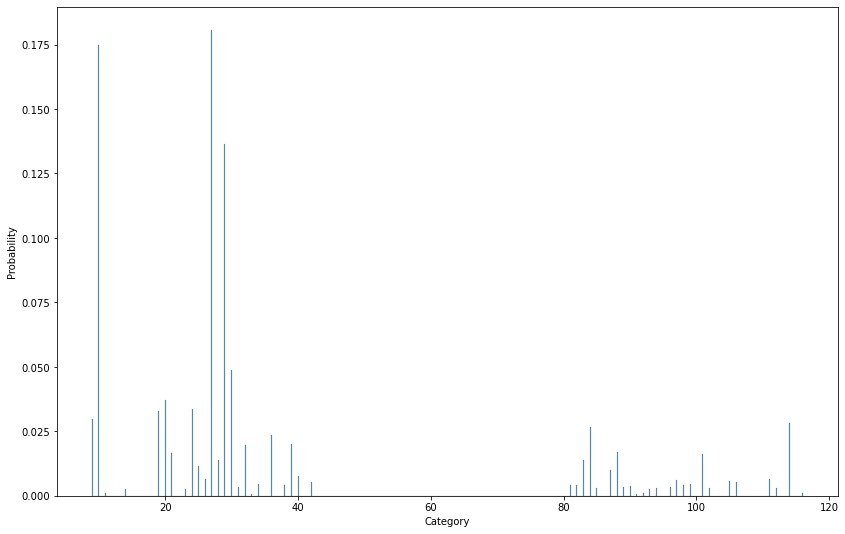

In [ ]:
# Построю столбчатую диаграмму при помощи библиотеки seaborn  
import seaborn as sns
from matplotlib import pyplot as plt
fig = plt.figure(figsize = (14,9)) # задаю размер графика

sns.histplot(train["Category"], stat = "probability") # строю график
plt.show()

In [ ]:
# Вывожу максимальную разницу между долями классов
print("Разброс долей: ", train["Category"].value_counts().values[0]/len(train) - train["Category"].value_counts().values[49]/len(train))

# Вывожу класс с наибольшей долей в тренировочной выборке и саму долю
print("Класс с наибольшей долей: ", train["Category"].value_counts().index[0]) # вывожу класс первого элемента в массиве подсчета значений
print("Доля: ", train["Category"].value_counts().values[0]/len(train)) # вывожу долю первого элемента в массиве подсчета значений

# Вывожу класс с наименьшей долей в тренировочной выборке и саму долю
print("Класс с наименьшей долей: ", train["Category"].value_counts().index[49]) # вывожу класс последнего элемента в массиве подсчета значений
print("Доля: ", train["Category"].value_counts().values[49]/len(train)) # вывожу долю последнего элемента в массиве подсчета значений

Разброс долей:  0.18066778742393202
Класс с наибольшей долей:  27
Доля:  0.1807067572782698
Класс с наименьшей долей:  86
Доля:  3.8969854337769914e-05


### Предобработка данных


In [ ]:
from sklearn.feature_extraction.text import CountVectorizer 
cnt_vec = CountVectorizer() # создаю объект класса
X = cnt_vec.fit_transform(train["td"]) # применяю CountVectorizer для тренировочных данных

In [ ]:
X

<4234042x2125805 sparse matrix of type '<class 'numpy.int64'>'
	with 150918485 stored elements in Compressed Sparse Row format>

Размер матрицы составляет 4234042x2125805 

In [ ]:
from string import punctuation
import re

dicti = list(cnt_vec.vocabulary_.keys()) # передаю все возможные значнения и формирую из них датафрейм

numbin = len(list(filter(re.compile(^r"[0-9]").match, dicti))) # выбираю только значения, которые начинаются с цифр
print("Всего слов, которые начинаются с цифры: ", numbin) 

punctin = list(filter(re.compile(^r"[{}]".format(punctuation)).match, dicti)) # выбираю только значения, которые начинаются с символов пунктуации
print("Все слова, которые начинаются на символы пунткуации:\n", punctin)
print("Всего таких слов: ", len(punctin)) 

Всего слов, которые начинаются с цифры:  610871
Все слова, которые начинаются на символы пунткуации:
 ['____________________________________________________', '______________________________________________________', '____________________________________________________________', '________________________________________________________', '_______________________________________________________', '______________________', '__основы', '__изучение', '__импровизация', '__жанровые', '___________________________________________', '__________________', '______________________________________________', '_____________________________________________________', '________________________________', '__________________________________________________', '________________________', '_________________________', '__________________________', '___________________________', '___________________________________________________', '________________________________________________', '________________________

In [ ]:
from nltk.stem.snowball import SnowballStemmer
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
import nltk
nltk.download('punkt')
nltk.download('stopwords')

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\Nazim\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\Nazim\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [ ]:
def tokenizer_ow(strok: str) -> list:
    strok = strok.lower() # перевожу все буквы в нижний регистр
    strok = word_tokenize(strok) # разделяю слова и символы пунктуации
    # беру значения, в которых нет цифр и символов пунктуации
    strok = pd.DataFrame(filter(re.compile(r"^[a-zа-я]+$").search, strok))
    # беру значения, которые не являются стоп-словами
    if not strok.empty: strok = strok[[let not in stopwords.words('russian') for let in strok[0]]]
    stemmer = SnowballStemmer('russian')
    stemmed = []
    # произвожу стемминг слов
    if not strok.empty: stemmed = [stemmer.stem(w) for w in strok[0]]
    return stemmed

In [ ]:
tokenizer_ow(train["td"][0])

['эб',
 'renault',
 'nissan',
 'dci',
 'delphi',
 'год',
 'комплект',
 'эб',
 'мозг',
 'компьютер',
 'мотор',
 'двигател',
 'коммутатор',
 'электрон',
 'блок',
 'управлен',
 'двигател',
 'компьютер',
 'мотор',
 'рен',
 'kangoo',
 'канг',
 'канг',
 'мега',
 'сценик',
 'laguna',
 'лагун',
 'clio',
 'кли',
 'nissan',
 'micra',
 'нисса',
 'микр',
 'друг',
 'рен',
 'нисса',
 'дизел',
 'топливн',
 'аппаратур',
 'делф',
 'оригина',
 'отличн',
 'состоян',
 'проверен',
 'гарант',
 'запчаст',
 'предоставля',
 'гарант',
 'возможн',
 'установк',
 'подробн',
 'раздел',
 'компан',
 'дорож',
 'сво',
 'репутац',
 'торгу',
 'легальн',
 'контрактн',
 'запчаст',
 'дета',
 'налич',
 'таможен',
 'документ',
 'запчаст',
 'автомобил',
 'пробег',
 'росс',
 'отправля',
 'друг',
 'регион',
 'таможен',
 'союз',
 'транспортн',
 'компан',
 'наложн',
 'платеж']

### SGDClassifier


In [ ]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import SGDClassifier
from sklearn.metrics import accuracy_score
from sklearn.pipeline import Pipeline

train_500 = train.sample(100000) # выбираю случайные строки из датасета
cnt_vec_1 = CountVectorizer(tokenizer = tokenizer_ow) # создаю CountVectorizer со своим токенизатором
X = cnt_vec_1.fit_transform(train_500["td"]) # трансформирую выборку

# разделяю выбранные строки на тестовую и тренировочную выборки
X_train, X_test, y_train, y_test = train_test_split(train_500["td"], train_500["Category"], test_size = 0.2, shuffle = True)

In [ ]:
# создаю классификатор
sgd = Pipeline([('vect', CountVectorizer(tokenizer = tokenizer_ow)), ('clf', SGDClassifier()),])
sgd.fit(X_train, y_train) # обучаю классификатор

print("Точность предсказания составляет:", accuracy_score(y_test, sgd.predict(X_test)))

Точность предсказания составляет: 0.8281


###  tf-idf векторизация


In [ ]:
from sklearn.feature_extraction.text import TfidfVectorizer

tfidf_vec = TfidfVectorizer(tokenizer = tokenizer_ow, max_df = 0.9) # создаю TfidfVectorizer со своим токенизатором
X = tfidf_vec.fit_transform(train_500["td"]) # трансформирую выборку

# создаю классификатор
sgd = Pipeline([('vect', TfidfVectorizer(tokenizer = tokenizer_ow, max_df = 0.9)), ('clf', SGDClassifier()),])
sgd.fit(X_train, y_train) # обучаю классификатор

print("Точность предсказания составляет:", accuracy_score(y_test, sgd.predict(X_test)))

Точность предсказания составляет: 0.832
  (0, 70732)	0.11899651121610993
  (0, 78963)	0.16200830089235596
  (0, 56036)	0.18158581763403234
  (0, 64765)	0.14609202576055735
  (0, 65938)	0.42826868481769936
  (0, 42817)	0.27814554633463484
  (0, 16473)	0.3674739981098324
  (0, 67673)	0.7137651581407033
  (1, 34125)	0.09655037618105443
  (1, 52058)	0.12237946098838429
  (1, 58138)	0.1414436085112835
  (1, 50863)	0.11181529828318214
  (1, 44867)	0.08321609974335734
  (1, 54596)	0.13328280994251288
  (1, 40775)	0.0906065580025261
  (1, 55425)	0.1252036812985375
  (1, 73057)	0.1290302306065464
  (1, 80020)	0.11617308958491457
  (1, 42702)	0.11470033947833404
  (1, 68047)	0.15848276921803048
  (1, 35776)	0.1078806283780616
  (1, 80698)	0.11150408218221584
  (1, 14337)	0.15620408014271991
  (1, 57274)	0.10510539061284879
  (1, 30626)	0.08600846867556221
  :	:
  (99998, 66585)	0.20185737383068697
  (99998, 76884)	0.2271606982333777
  (99998, 71573)	0.21633335410807938
  (99998, 59903)	0.2003272

In [ ]:
X

<100000x83041 sparse matrix of type '<class 'numpy.float64'>'
	with 2440307 stored elements in Compressed Sparse Row format>

Матрица уменьшилась, а точность модели повысилась.

### HashingVectorizer


In [ ]:
from sklearn.feature_extraction.text import HashingVectorizer

hash_vec = HashingVectorizer(tokenizer = tokenizer_ow, n_features = 30000)  # создаю HashingVectorizer со своим токенизатором
X = hash_vec.fit_transform(train_500["td"])  # трансформирую выборку

# создаю классификатор
sgd = Pipeline([('vect', HashingVectorizer(tokenizer = tokenizer_ow, n_features = 30000)), ('clf', SGDClassifier()),])
sgd.fit(X_train, y_train) # обучаю классификатор

print("Точность предсказания составляет:", accuracy_score(y_test, sgd.predict(X_test)))

X

Точность предсказания составляет: 0.81225
  (0, 2012)	-0.30151134457776363
  (0, 4916)	0.30151134457776363
  (0, 5715)	-0.30151134457776363
  (0, 8986)	-0.30151134457776363
  (0, 13157)	-0.30151134457776363
  (0, 20226)	-0.30151134457776363
  (0, 24112)	0.30151134457776363
  (0, 27872)	-0.6030226891555273
  (1, 1277)	-0.11470786693528087
  (1, 1316)	-0.22941573387056174
  (1, 1588)	-0.11470786693528087
  (1, 2197)	0.11470786693528087
  (1, 2590)	-0.22941573387056174
  (1, 3172)	0.11470786693528087
  (1, 4195)	-0.11470786693528087
  (1, 5929)	-0.11470786693528087
  (1, 6533)	0.11470786693528087
  (1, 6576)	0.22941573387056174
  (1, 6819)	0.11470786693528087
  (1, 7216)	-0.11470786693528087
  (1, 8344)	0.22941573387056174
  (1, 8448)	-0.4588314677411235
  (1, 9644)	-0.11470786693528087
  (1, 10094)	-0.11470786693528087
  (1, 10239)	-0.11470786693528087
  :	:
  (99998, 4362)	-0.17677669529663687
  (99998, 6723)	0.17677669529663687
  (99998, 7579)	0.17677669529663687
  (99998, 7955)	-0.176

In [ ]:
X

<100000x30000 sparse matrix of type '<class 'numpy.float64'>'
	with 2438296 stored elements in Compressed Sparse Row format>

Лучший результат показал векторизатор TfidVectorizer, недалеко ушел векторизатор CountVectorizer. Худший же результат у векторизатора  HashingVectorizer.